In [1]:
import utils
import agreement

import logging

import pandas as pd

logging.captureWarnings(True)

## Load form responses from pilot 3, pilot4 trial, and pilot 4 main task

In [2]:
responses_path3 = "pilot3-trial3/results/form_data/processed/responses.csv"
responses_path4 = "pilot4/results/form_data/processed/responses.csv"
responses_path4_trial = "pilot4/results/form_data_trial/processed/responses.csv"

responses3 = utils.read_processed_data(responses_path3)
responses3 = responses3.loc[responses3['field'] != 'edit']
responses3['task'] = 'pilot3'

responses4 = utils.read_processed_data(responses_path4)
responses4 = responses4.loc[responses4['field'] != 'edit']
responses4['task'] = 'pilot4'

responses4_trial = utils.read_processed_data(responses_path4_trial)
responses4_trial = responses4_trial.loc[responses4_trial['field'] != 'edit']
responses4_trial['task'] = 'pilot4_trial'

responses = pd.concat([responses3, responses4])

Reading processed data from pilot3-trial3/results/form_data/processed/responses.csv.
Index(['source', 'snippet_end', 'question_index', 'session_id', 'field_id',
       'field', 'snippet_id', 'question_id', 'response', 'filename',
       'run_name', 'study_id', 'work_unit_id', 'participant_id',
       'snippet_start', 'field_shorter'],
      dtype='object')
38 participants
6 work_units
63 sessions
11 snippet index
11 snippet i
3 snippet id (!!!)
49 questions index
9 questions id (!!!)
49 questions i
Reading processed data from pilot4/results/form_data/processed/responses.csv.
Index(['source', 'snippet_end', 'question_index', 'session_id', 'field_id',
       'field', 'snippet_id', 'question_id', 'response', 'filename',
       'run_name', 'study_id', 'work_unit_id', 'participant_id',
       'snippet_start', 'field_shorter'],
      dtype='object')
23 participants
6 work_units
58 sessions
11 snippet index
11 snippet i
2 snippet id (!!!)
52 questions index
9 questions id (!!!)
52 questions i

## Add various info to measure annotator quality

In [3]:
annotation_files = [
    'annotation/annotation_sample_1_hj_H.txt',
    'annotation/annotation_sample_1_hj_J.txt',
    'annotation/annotation_sample_1_hj_HJ.txt',
    'annotation/annotation_sample_2_lm_L.txt',
    'annotation/annotation_sample_2_lm_M.txt',
    'annotation/annotation_sample_2_lm_LM.txt',
    'annotation/annotation_recall_sample_2_lm_L.txt',
    'annotation/annotation_recall_sample_2_lm_M.txt',
    'annotation/annotation_recall_sample_2_lm_LM.txt',
    'annotation/annotation_recall_sample_1_hj_H.txt',
    'annotation/annotation_recall_sample_1_hj_M.txt',
    'annotation/annotation_recall_sample_1_hj_HM.txt',
]

annotations = utils.read_annotation_files(annotation_files)
annotations_aggregated = agreement.aggregate_annotations(annotations)
expert_labels = annotations_aggregated.to_dict()['A']   # Very obscure code, but boils down to using our 'agreed upon' annotations from the LM/HM/HJ files.
responses['expert'] = [expert_labels.get((row['question_index'], row['field'])) for _, row in responses.iterrows()]


majority_labels = agreement.get_majority_labels(responses, threshold=0.15)
responses['majority'] = [majority_labels.get((row['question_index'], row['field'])) for _, row in responses.iterrows()]

responses3 = responses.loc[responses['task'] == 'pilot3']
responses4 = responses.loc[responses['task'] == 'pilot4']

agreement.add_meets_criteria(responses4_trial)  # adds 'meets_criterion' column.

## Determine and then exclude the worst participants in various ways (criteria, mcc_expert, mcc_majority)

In [21]:
worst_by_criteria = responses4_trial.groupby('participant_id')['meets_criterion'].mean().sort_values().reset_index()
worst_by_mcc_expert3 = agreement.scores_by(responses3, by=['participant_id'], gold_label='expert').sort_values('mcc')
worst_by_mcc_expert4 = agreement.scores_by(responses4, by=['participant_id'], gold_label='expert').sort_values('mcc')
worst_by_mcc_majority3 = agreement.scores_by(responses3, by=['participant_id'], gold_label='majority').sort_values('mcc')
worst_by_mcc_majority4 = agreement.scores_by(responses4, by=['participant_id'], gold_label='majority').sort_values('mcc')

# Lots of arbitrary thresholds here...

worst_participants_by_criteria = worst_by_criteria.loc[worst_by_criteria['meets_criterion'] < 0.7].participant_id

ratio_3_4 = len(worst_by_mcc_expert3)/len(worst_by_mcc_expert4)

worst_participants_by_mcc_expert3 = list(worst_by_mcc_expert3.participant_id[:round(6 * ratio_3_4)])
worst_participants_by_mcc_majority3 = list(worst_by_mcc_majority3.participant_id[:round(6 * ratio_3_4)])
worst_participants_by_mcc_expert4 = list(worst_by_mcc_expert4.participant_id[:6])
worst_participants_by_mcc_majority4 = list(worst_by_mcc_majority4.participant_id[:6])


# bad_sessionids = ['60fc0d0d296b42c5fa1ffbf4', '5f1ebf038091f202472ec14d', '5c658ef1085e6a0001fec464']
# suspicious_sessionids = ['63d2945926a140d95fbc7914' '63d3f949aca63e00ed85cf8b', '5bbbbfa90efb290001674ecc']
# responses_filtered = responses.loc[~responses['session_id'].isin(bad_sessionids + suspicious_sessionids)]

responses_filtered_by_criteria = responses.loc[~responses['participant_id'].isin(worst_participants_by_criteria)]
responses_filtered_by_mcc_gold = responses.loc[~responses['participant_id'].isin(worst_participants_by_mcc_expert3 + worst_participants_by_mcc_expert4)]
responses_filtered_by_mcc_majority = responses.loc[~responses['participant_id'].isin(worst_participants_by_mcc_majority3 + worst_participants_by_mcc_majority4)]

## Which sessions are excluded from pilot 4 in these three ways?

In [22]:
sessions_excluded_by_criteria = responses4.loc[responses4.participant_id.isin(worst_participants_by_criteria)].groupby('participant_id')['session_id'].agg(set)
sessions_excluded_by_criteria

participant_id
100    {63da6bfea9672642bd188cc2, 63da6e1b5967746eeeb...
84     {63dad26cb6736b0ead0fd372, 63dacc2c3760c0194d6...
86     {63da6801aa2e56e1a9d49d94, 63da72a8d67fb2f0916...
88     {63da721ad07e0fb30e991a60, 63da6f279e31e4946cd...
97     {63dacfbb2da0b4d05954a448, 63dabfc38f29790c264...
99     {63da7e6e4f0b781f1d25f551, 63da724e64759157314...
Name: session_id, dtype: object

In [23]:
sessions_excluded_by_mcc_expert = responses4.loc[responses4.participant_id.isin(worst_participants_by_mcc_expert4)].groupby('participant_id')['session_id'].agg(set)
sessions_excluded_by_mcc_expert

participant_id
100    {63da6bfea9672642bd188cc2, 63da6e1b5967746eeeb...
72     {63da7a96f0c297e358646cc0, 63da729872383a57568...
73     {63da95d02b98f8ce864c84c5, 63da909d5d3a470f43a...
84     {63dad26cb6736b0ead0fd372, 63dacc2c3760c0194d6...
87     {63da6dbb0d70daf7a5d7046b, 63da6a9cc1d26022bc2...
88     {63da721ad07e0fb30e991a60, 63da6f279e31e4946cd...
Name: session_id, dtype: object

In [24]:
sessions_excluded_by_mcc_majority = responses4.loc[responses4.participant_id.isin(worst_participants_by_mcc_majority4)].groupby('participant_id')['session_id'].agg(set)
sessions_excluded_by_mcc_majority

participant_id
84    {63dad26cb6736b0ead0fd372, 63dacc2c3760c0194d6...
86    {63da6801aa2e56e1a9d49d94, 63da72a8d67fb2f0916...
87    {63da6dbb0d70daf7a5d7046b, 63da6a9cc1d26022bc2...
96    {63da825a0315dc0615aa2fbc, 63daa7d6c5f42ede5a9...
97    {63dacfbb2da0b4d05954a448, 63dabfc38f29790c264...
99    {63da7e6e4f0b781f1d25f551, 63da724e64759157314...
Name: session_id, dtype: object

## Scores before excluding any annotators

In [26]:
agreement.scores_by(responses, by=['task'], gold_label='expert')

,task,spearman,precision,recall,mcc,f1score
0,pilot3,0.480668,0.483601,0.533575,0.315985,0.50736
1,pilot4,0.459887,0.469122,0.517864,0.297037,0.49229


In [27]:
agreement.scores_by(responses, by=['task'], gold_label='majority')

,task,spearman,precision,recall,mcc,f1score
0,pilot3,0.632020,0.940233,0.407261,0.359629,0.568345
1,pilot4,0.631235,0.936012,0.404697,0.355945,0.565076


## Scores after excluding annotators based on criteria (affects pilot 4 only!)

In [28]:
agreement.scores_by(responses_filtered_by_criteria, by=['task'], gold_label='expert')

,task,spearman,precision,recall,mcc,f1score
0,pilot3,0.480668,0.483601,0.533575,0.315985,0.50736
1,pilot4,0.493440,0.484657,0.558675,0.329094,0.51904


In [29]:
agreement.scores_by(responses_filtered_by_criteria, by=['task'], gold_label='majority')

,task,spearman,precision,recall,mcc,f1score
0,pilot3,0.632020,0.940233,0.407261,0.359629,0.568345
1,pilot4,0.667513,0.941062,0.427528,0.377866,0.587949


## Scores after excluding annotators based their performance on the task itself (given our expert annotations)

In [30]:
agreement.scores_by(responses_filtered_by_mcc_gold, by=['task'], gold_label='expert')

,task,spearman,precision,recall,mcc,f1score
0,pilot3,0.49783,0.513423,0.553202,0.353037,0.532571
1,pilot4,0.51540,0.511678,0.535836,0.346411,0.523479


In [31]:
agreement.scores_by(responses_filtered_by_mcc_gold, by=['task'], gold_label='majority')

,task,spearman,precision,recall,mcc,f1score
0,pilot3,0.639602,0.941515,0.401883,0.360900,0.563316
1,pilot4,0.707764,0.950570,0.390712,0.364475,0.553797


## Scores after excluding annotators based their performance on the task itself (given the majority vote)

In [32]:
agreement.scores_by(responses_filtered_by_mcc_majority, by=['task'], gold_label='expert')

,task,spearman,precision,recall,mcc,f1score
0,pilot3,0.490471,0.481481,0.571759,0.330642,0.522751
1,pilot4,0.491815,0.482552,0.567742,0.331076,0.521692


In [33]:
agreement.scores_by(responses_filtered_by_mcc_majority, by=['task'], gold_label='majority')

,task,spearman,precision,recall,mcc,f1score
0,pilot3,0.643881,0.951754,0.447013,0.403042,0.608316
1,pilot4,0.669512,0.947657,0.440454,0.395290,0.601392



---------------


['clarity', 'naturalness', 'class', 'reason', 'status', 'alreadyanswered', 'willbeanswered', 'shortanswer', 'specificity', 'rephrasing', 'mainpoint']


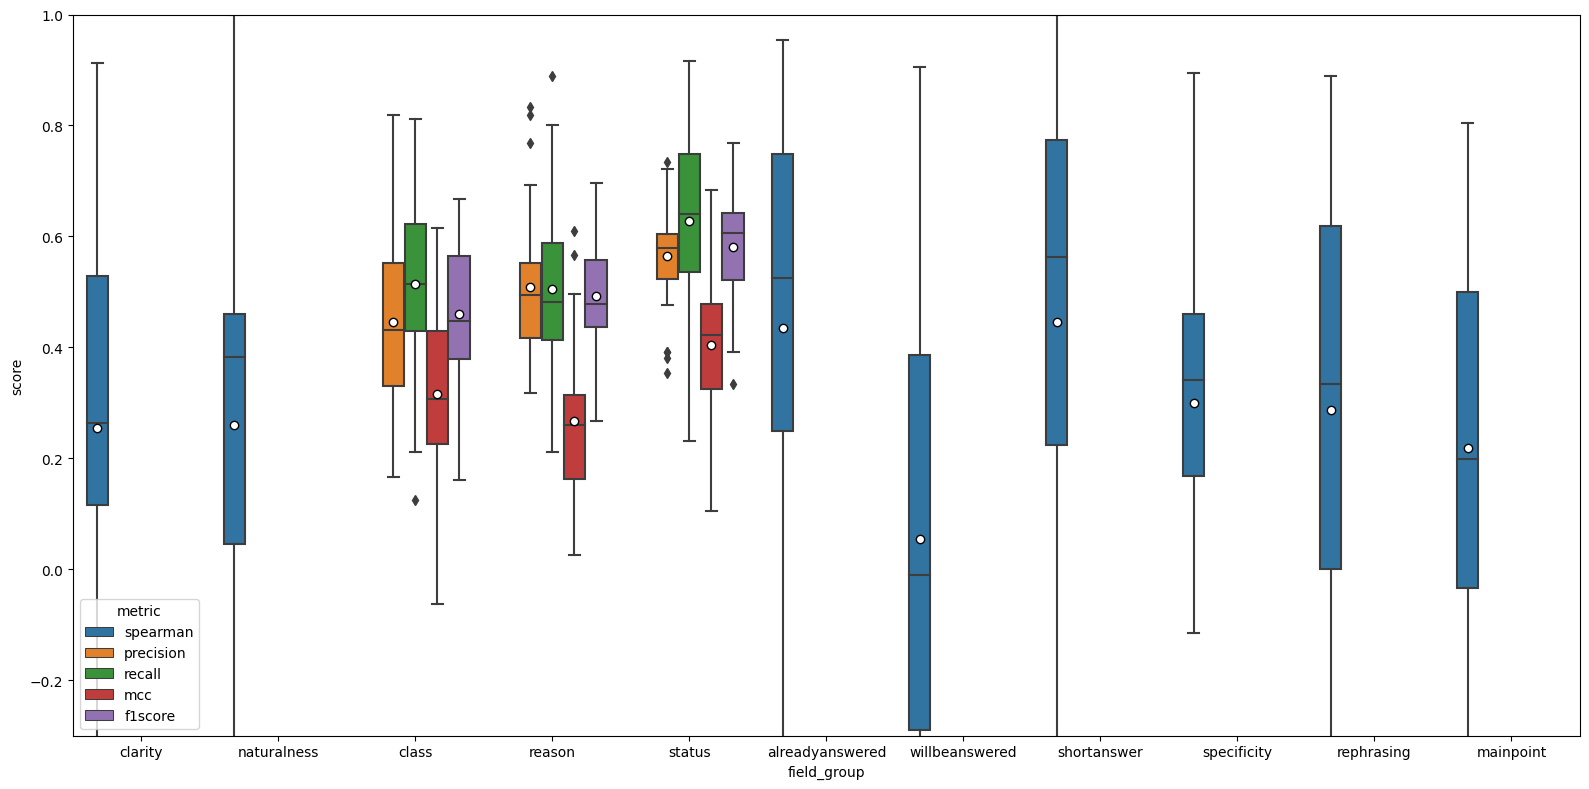

['clarity', 'naturalness', 'class', 'reason', 'status', 'alreadyanswered', 'willbeanswered', 'shortanswer', 'specificity', 'rephrasing', 'mainpoint']


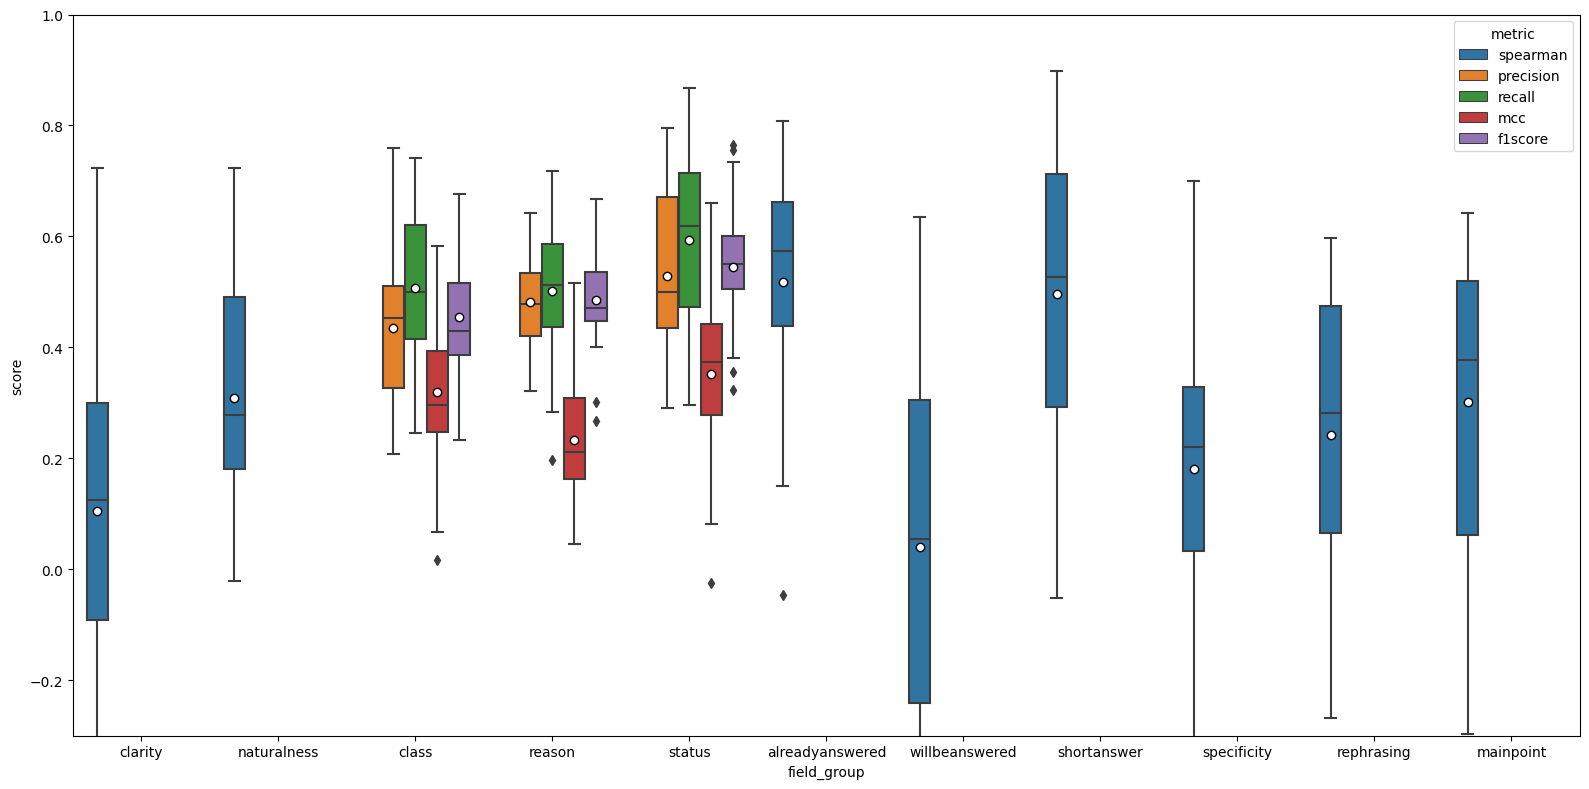

In [34]:
agreement.plot_scores_by(responses3, by='field_group', variance_by='participant_id', gold_label='expert')
agreement.plot_scores_by(responses4, by='field_group', variance_by='participant_id', gold_label='expert')

Int64Index([32, 11, 31, 35, 34, 14, 27,  6, 43, 17,  3, 46, 39,  7,  8, 16,  2,
            29, 41,  5, 20, 25, 47, 38,  0, 30, 18, 23, 40, 21,  9, 42, 22],
           dtype='int64', name='question_i')


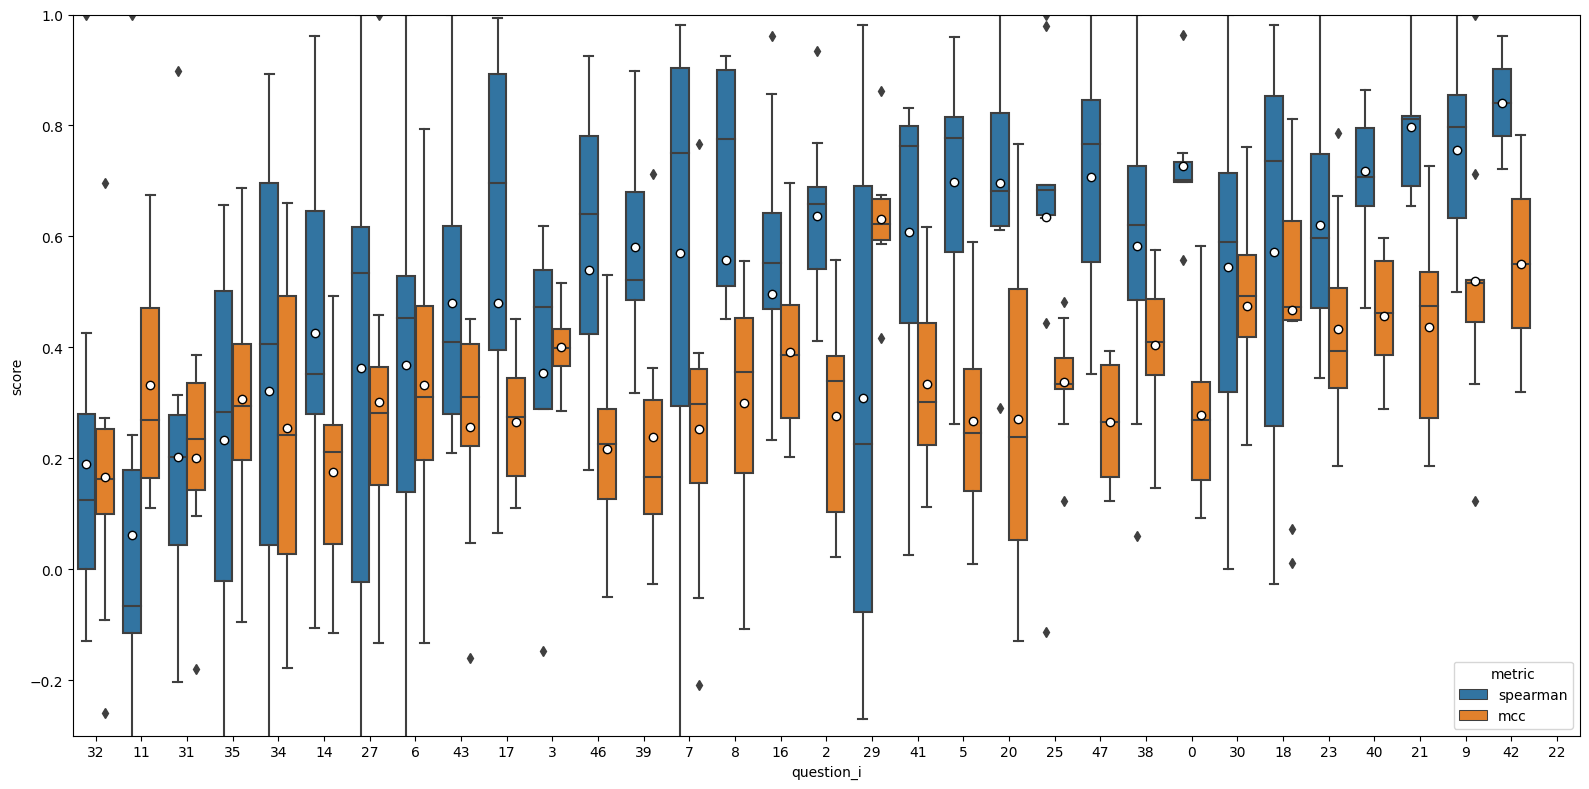

Int64Index([35, 12,  3,  7, 37, 32, 34, 47, 43, 39,  2,  0, 50, 33,  5, 45, 51,
            28, 42, 21, 10, 19, 18, 15, 24, 44, 17, 22, 26,  6, 46, 30,  9,  8,
            23],
           dtype='int64', name='question_i')


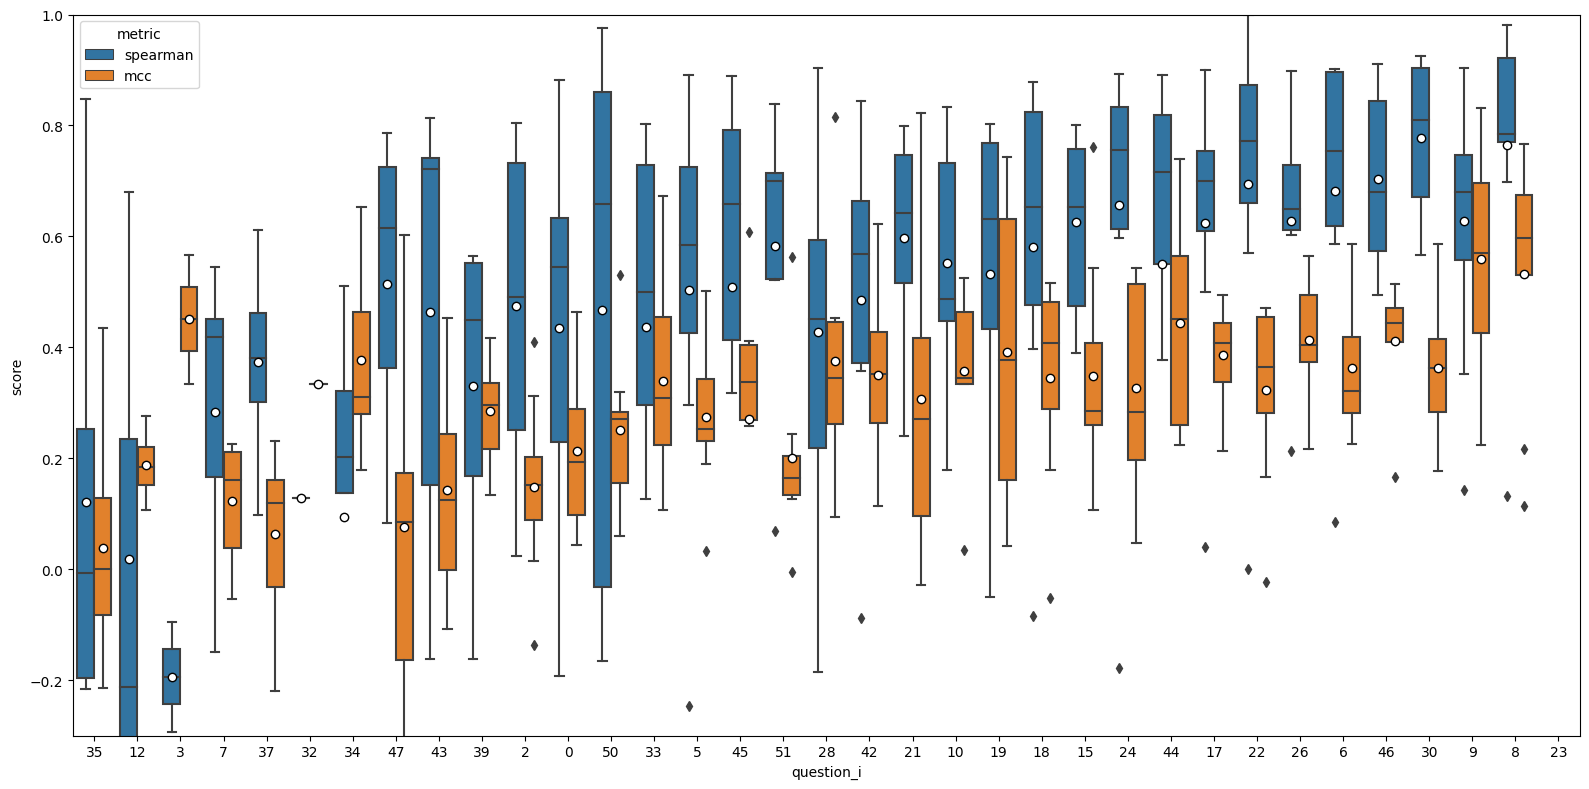

In [35]:
agreement.plot_scores_by(responses3, by='question_i', variance_by='participant_id', gold_label='expert')
agreement.plot_scores_by(responses4, by='question_i', variance_by='participant_id', gold_label='expert')

Int64Index([31, 17, 42, 60, 62, 43,  5,  3, 57, 63, 58, 68, 24, 19, 67, 32, 11,
             7, 44, 52, 59,  2, 47,  8, 34, 46, 49, 28, 38, 12, 30, 36, 40,
            33],
           dtype='int64', name='participant_id')


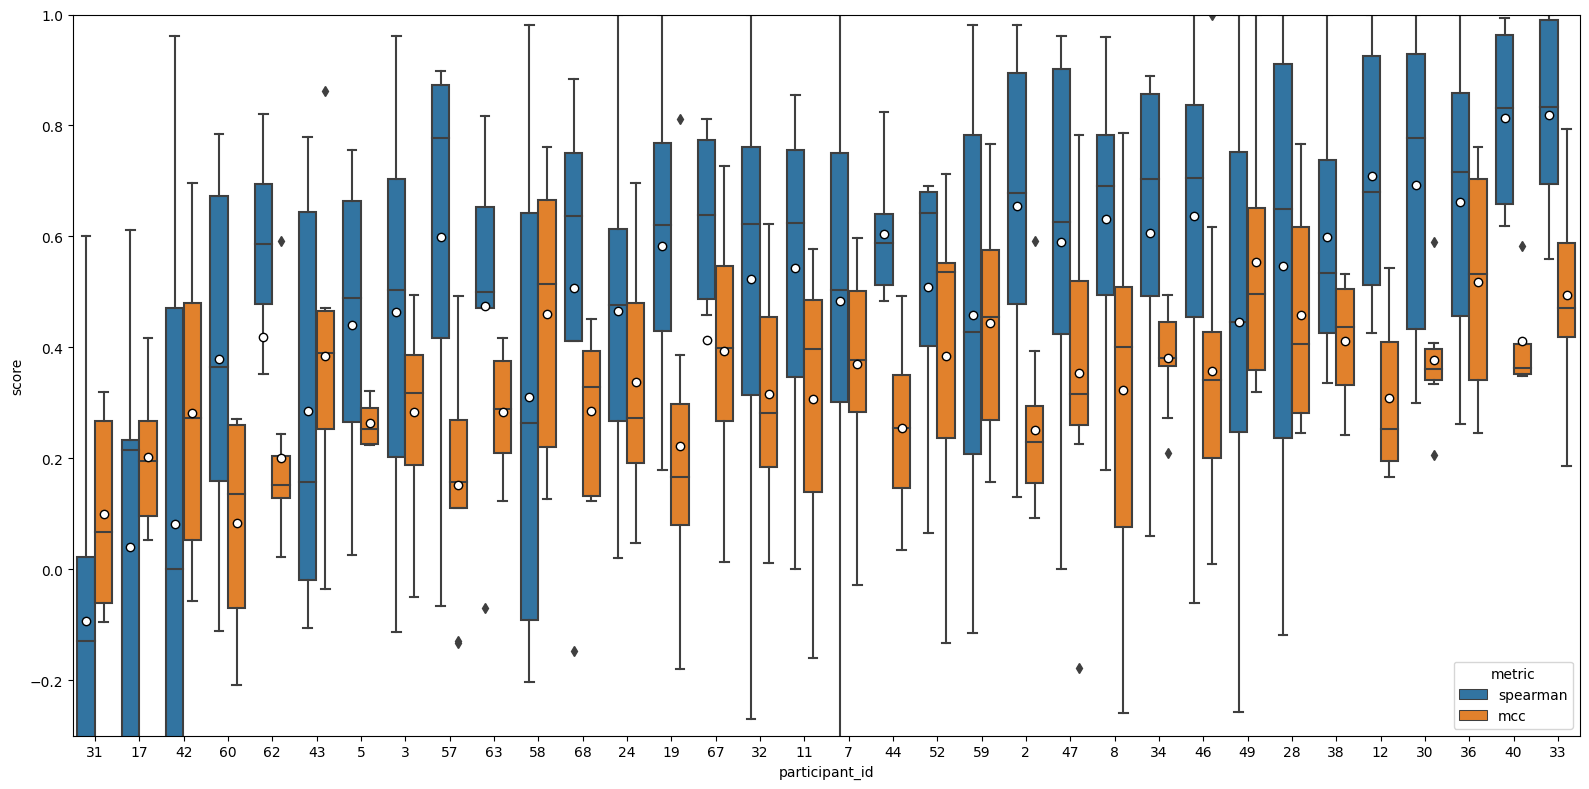

Index(['84', '87', '100', '98', '88', '91', '72', '86', '73',
       'P_63da8b4039a0837994ca4859', '99', '89', '85', '81', '83', '92', '97',
       '79', '96', '95', '80', '94', '75'],
      dtype='object', name='participant_id')


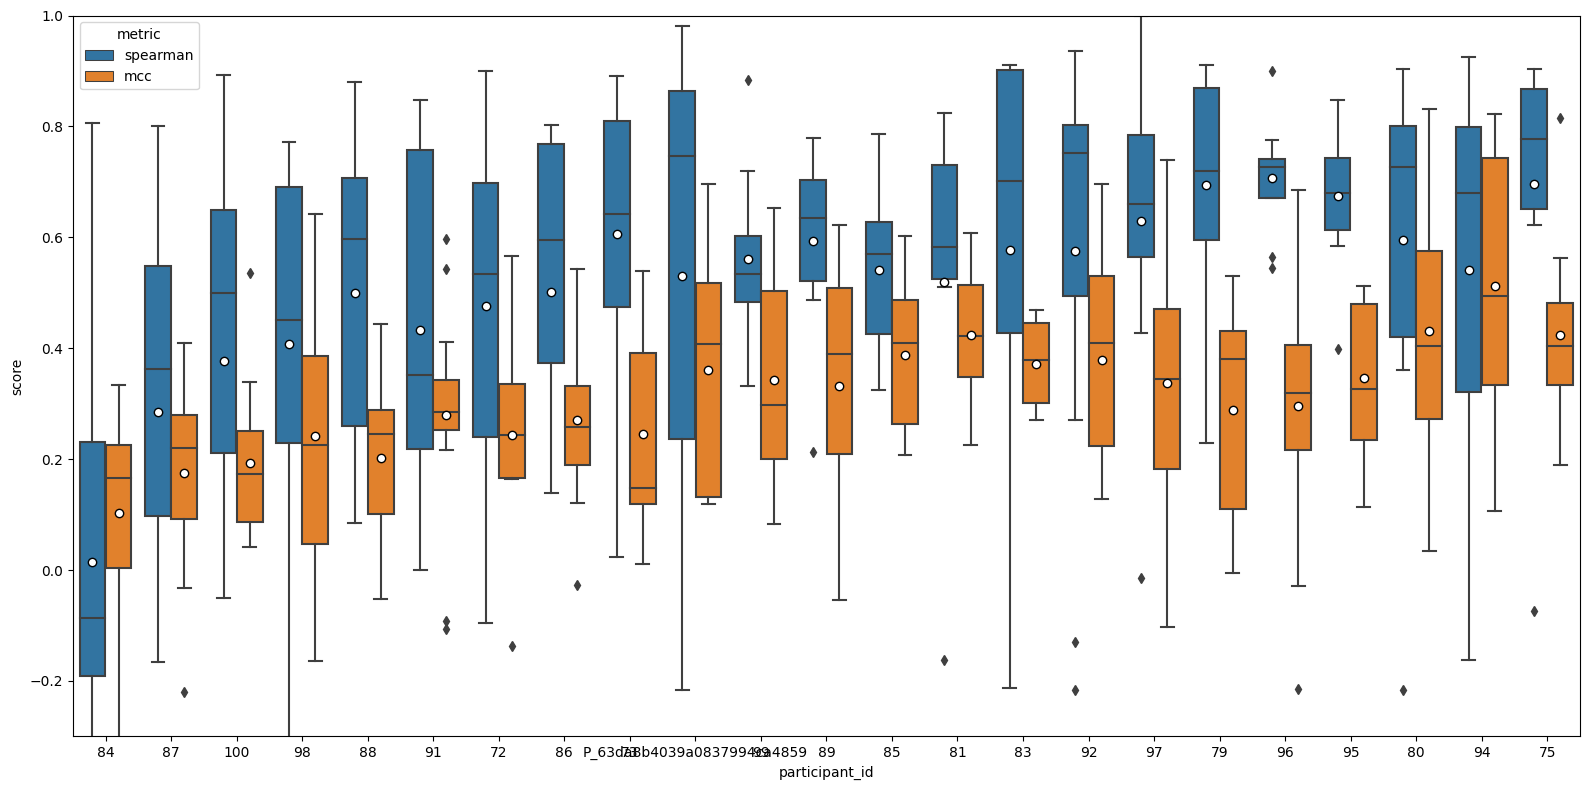

In [36]:
agreement.plot_scores_by(responses3, by='participant_id', variance_by='question_i', gold_label='expert')
agreement.plot_scores_by(responses4, by='participant_id', variance_by='question_i', gold_label='expert')